In [13]:
from astroquery.gaia import Gaia
from astroquery.esasky import ESASky
import numpy as np
from simbad_download import resolve_name
import pandas as pd
import pyvo as vo
import gaia_download as gd
from cross_match import add_panstarrs1, add_twomass
import matplotlib.pyplot as plt
from extinction import add_color, mag_abs, add_colors_and_abs_mag

1. arcesonds

In [7]:
sources = pd.read_csv('./found_cp_tails.csv')

In [8]:
gaia_data = gd.gaia_download_data(sources.source_id.values)

Executing Gaia query for 1050 sources...
Executing query...
INFO: Query finished. [astroquery.utils.tap.core]
Query finished!


In [11]:
sources_dr3 = pd.merge(left=gaia_data, right=sources[['source_id', 'TIC']], on='source_id', how='left')

In [12]:
sources_dr3.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,TIC
0,1636148068921376768,Gaia DR3 573545534662757504,573545534662757504,843580694,2016.0,10.732846,0.238209,84.682801,0.235746,0.523439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1636148068921376768,Gaia DR3 573549009293487360,573549009293487360,117320301,2016.0,9.938466,0.017343,84.833263,0.015769,0.509673,...,0.3516,0.3785,0.3000,0.2862,0.3085,0.1604,0.1530,0.1649,PHOENIX,461598969.0
2,1636148068921376768,Gaia DR3 573549932709068416,573549932709068416,349334707,2016.0,12.411280,0.060851,84.778756,0.051277,0.479208,...,0.3281,0.4416,0.2968,0.2580,0.3485,0.1590,0.1382,0.1865,PHOENIX,NaN
3,1636148068921376768,Gaia DR3 573552475329793152,573552475329793152,1255013827,2016.0,12.264538,0.048599,84.907228,0.039843,0.532028,...,0.0679,0.1218,0.0764,0.0541,0.0973,0.0405,0.0287,0.0516,PHOENIX,461618421.0
4,1636148068921376768,Gaia DR3 573552651425754240,573552651425754240,1610097616,2016.0,11.786204,0.056529,84.867786,0.051901,0.572127,...,0.2256,0.2827,0.2018,0.1771,0.2226,0.1062,0.0932,0.1172,PHOENIX,NaN


In [14]:
sources_dr3 = add_colors_and_abs_mag(sources_dr3)

In [15]:
sources_with_panstarrs = add_panstarrs1(sources_dr3)

INFO: Query finished. [astroquery.utils.tap.core]
panstarrs1 cross-match: 998 sources


In [16]:
sources_with_panstarrs = add_color(sources_with_panstarrs, 'g', 'r')
sources_with_panstarrs = mag_abs(sources_with_panstarrs, 'g')

In [17]:
sources_with_panstarrs = sources_with_panstarrs[np.abs(sources_with_panstarrs['g-r'])<10]
sources_with_panstarrs = sources_with_panstarrs[np.abs(sources_with_panstarrs['g_abs'])<30]

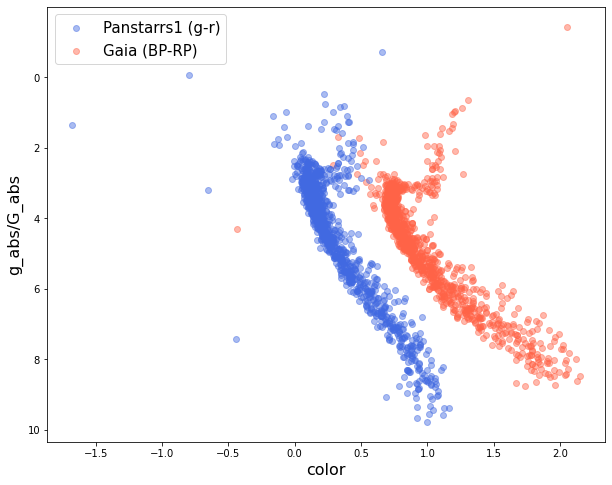

In [22]:
plt.figure(figsize=(10, 8))
plt.scatter(sources_with_panstarrs['g-r'], sources_with_panstarrs.g_abs,
            color='royalblue', label='Panstarrs1 (g-r)', alpha=.45, zorder=2)
plt.scatter(sources_with_panstarrs['BP-RP'], sources_with_panstarrs['G_abs'],
            color='tomato', label='Gaia (BP-RP)', alpha=.45)
plt.gca().invert_yaxis();
plt.legend(fontsize=15);
plt.gca().set_ylabel('g_abs/G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);

In [23]:
sources_all = add_twomass(sources_with_panstarrs)

INFO: Query finished. [astroquery.utils.tap.core]
tmass_psc_xsc cross-match: 919 sources
INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [24]:
%matplotlib notebook  

In [25]:
from sklearn.ensemble import IsolationForest

In [26]:
color_mag_abs = sources_all[['BP-RP', 'G_abs']]

In [27]:
clf = IsolationForest(contamination=0.25).fit_predict(color_mag_abs.values)

In [28]:
sources_all['outlier'] = clf

<IPython.core.display.Javascript object>


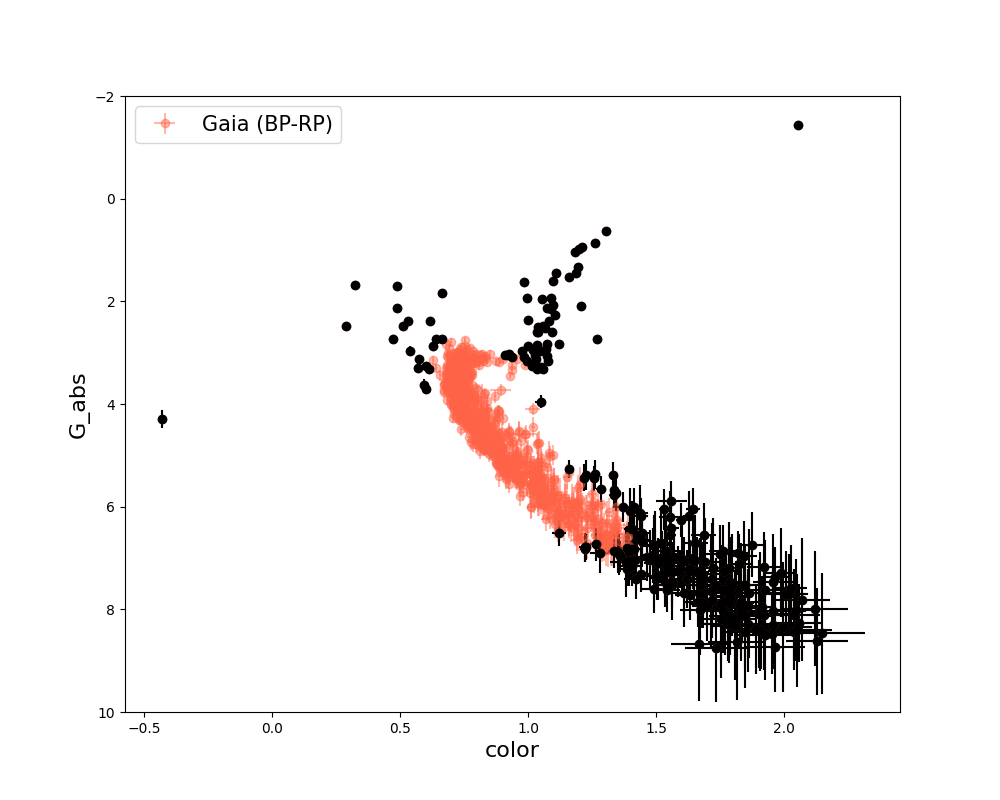

In [31]:
plt.figure(figsize=(10, 8))
plt.errorbar(sources_all['BP-RP'], sources_all['G_abs'],
             xerr=sources_all['BP-RP_error'], yerr=sources_all['G_abs_error'],
             color='tomato', label='Gaia (BP-RP)', alpha=.45, fmt='o')
plt.errorbar(sources_all[sources_all.outlier==-1]['BP-RP'], sources_all[sources_all.outlier==-1]['G_abs'],
             xerr=sources_all[sources_all.outlier==-1]['BP-RP_error'],
             yerr=sources_all[sources_all.outlier==-1]['G_abs_error'],
            color='black', fmt='o', zorder=2);
plt.gca().invert_yaxis();
plt.legend(fontsize=15);
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.gca().set_ylim(10, -2);


In [32]:
isochrone = np.loadtxt('./cmd_test.dat', usecols=(28, 29, 30))

In [33]:
isochrone.shape

(297, 3)

In [34]:
isochrone = isochrone[isochrone[:, 1]<25]

<IPython.core.display.Javascript object>


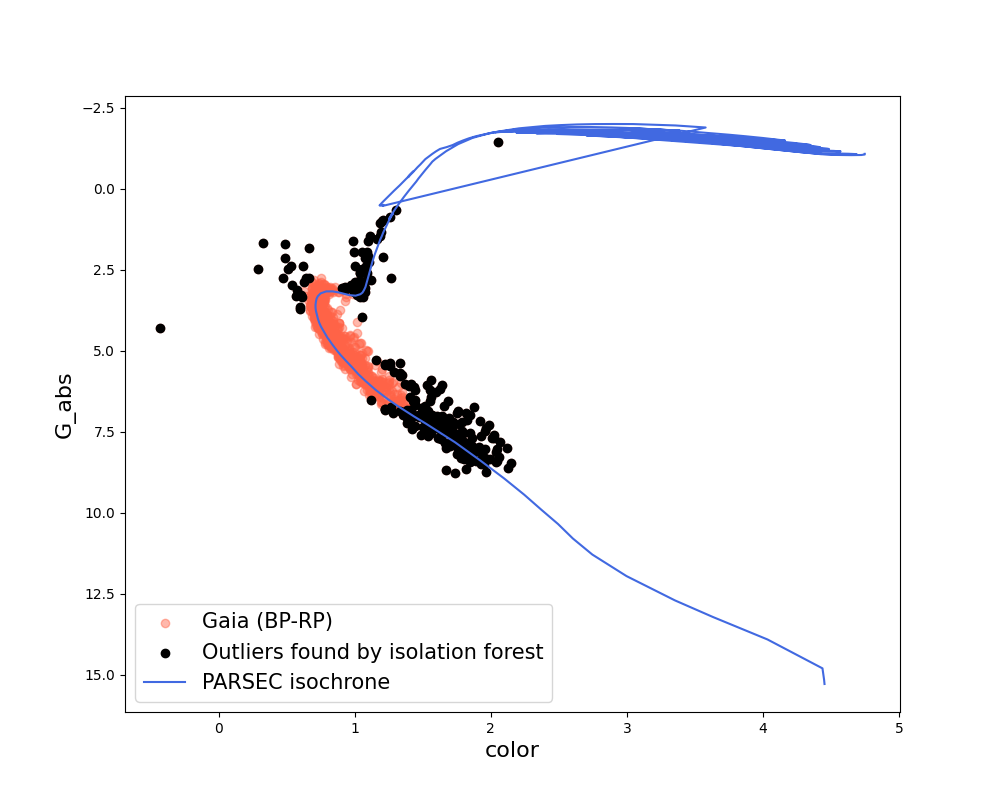

In [37]:
plt.figure(figsize=(10, 8))
plt.scatter(sources_all['BP-RP'], sources_all['G_abs'],
            color='tomato', label='Gaia (BP-RP)', alpha=.45)
plt.scatter(sources_all[sources_all.outlier==-1]['BP-RP'], sources_all[sources_all.outlier==-1]['G_abs'],
            color='black', label='Outliers found by isolation forest')
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone[:, 1]-isochrone[:, 2], isochrone[:, 0], label='PARSEC isochrone', color='royalblue')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

Constrain the isochrone to the part that interests me

<IPython.core.display.Javascript object>


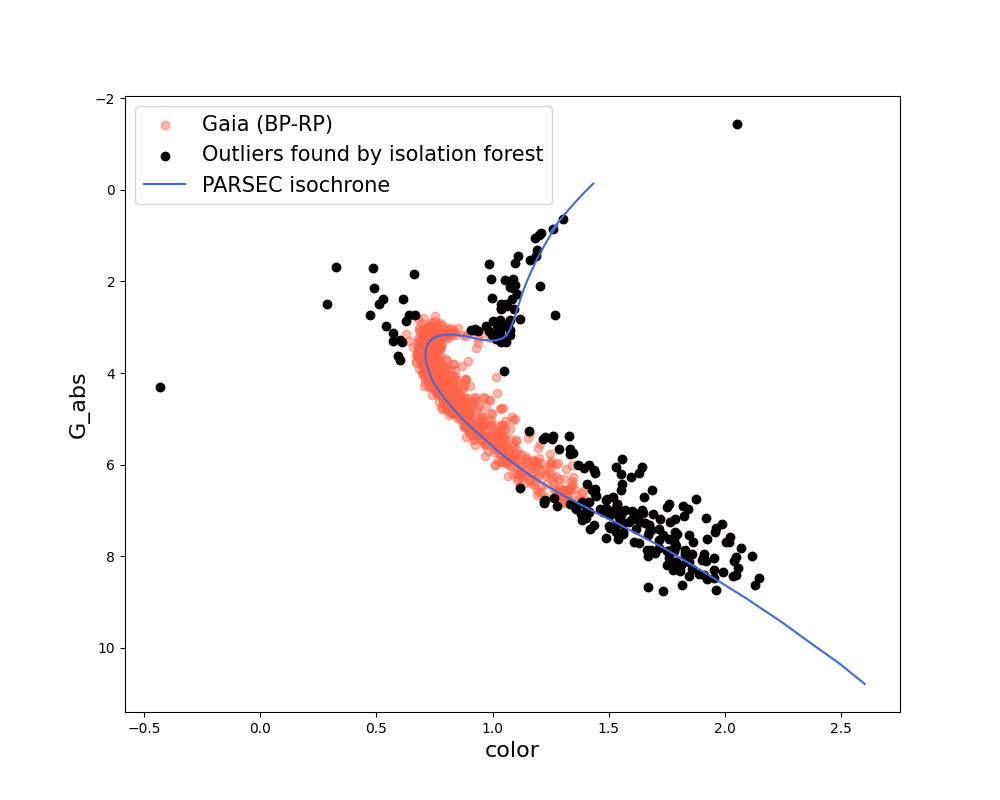

In [38]:
plt.figure(figsize=(10, 8))

isochrone_start_ind = 10
isochrone_end_ind = 100

plt.scatter(sources_all['BP-RP'], sources_all['G_abs'],
            color='tomato', label='Gaia (BP-RP)', alpha=.45)
plt.scatter(sources_all[sources_all.outlier==-1]['BP-RP'], sources_all[sources_all.outlier==-1]['G_abs'],
            color='black', label='Outliers found by isolation forest')
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone[isochrone_start_ind:isochrone_end_ind, 1]-isochrone[isochrone_start_ind:isochrone_end_ind, 2],
         isochrone[isochrone_start_ind:isochrone_end_ind, 0], label='PARSEC isochrone', color='royalblue')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

In [39]:
isochrone_cut = isochrone[isochrone_start_ind:isochrone_end_ind]
isochrone_cut = np.concatenate([
    (isochrone_cut[:, 1]-isochrone_cut[:, 2]).reshape(-1, 1),
    isochrone_cut[:, 0].reshape(-1, 1)], axis=1)

In [40]:
from scipy.interpolate import interp1d

In [41]:
BOUNDS = np.max(isochrone_cut, axis=0)-np.min(isochrone_cut, axis=0)

In [42]:
BOUNDS

array([ 1.892, 10.926])

In [150]:
def closest(source, isochrone):
    two_closest = isochrone[
    np.argsort(
            np.linalg.norm((source-isochrone), axis=1).flatten()
        )
    ][:2]
    return two_closest[0], two_closest[1]

def distance_to_closest(source, isochrone):
    src_rescaled = source/BOUNDS
    isochrone_rescaled = isochrone/BOUNDS
    p1, p2 = closest(src_rescaled, isochrone_rescaled)
    return np.linalg.norm(np.cross((p2-p1), (p1-src_rescaled)))/np.linalg.norm((p2-p1))

def above_isochrone(source, isochrone, verbose=False):
    p1, p2 = closest(source, isochrone)
    if verbose:
        print('Closest points:', p1, p2)
    point = interp1d([p1[0], p2[0]], [p1[1], p2[1]], fill_value='extrapolate')(source[0])
    if verbose:
        print(point)
    return source[1] <= point

In [151]:
dists = np.apply_along_axis(
    lambda x: distance_to_closest(x, isochrone_cut), 1,
    sources_all[['BP-RP', 'G_abs']].values)

In [152]:
above_equal_binary_limit = np.apply_along_axis(
    lambda x: above_isochrone(x, isochrone_cut+np.array([0., -0.75])), 1,
    sources_all[['BP-RP', 'G_abs']].values)

<IPython.core.display.Javascript object>


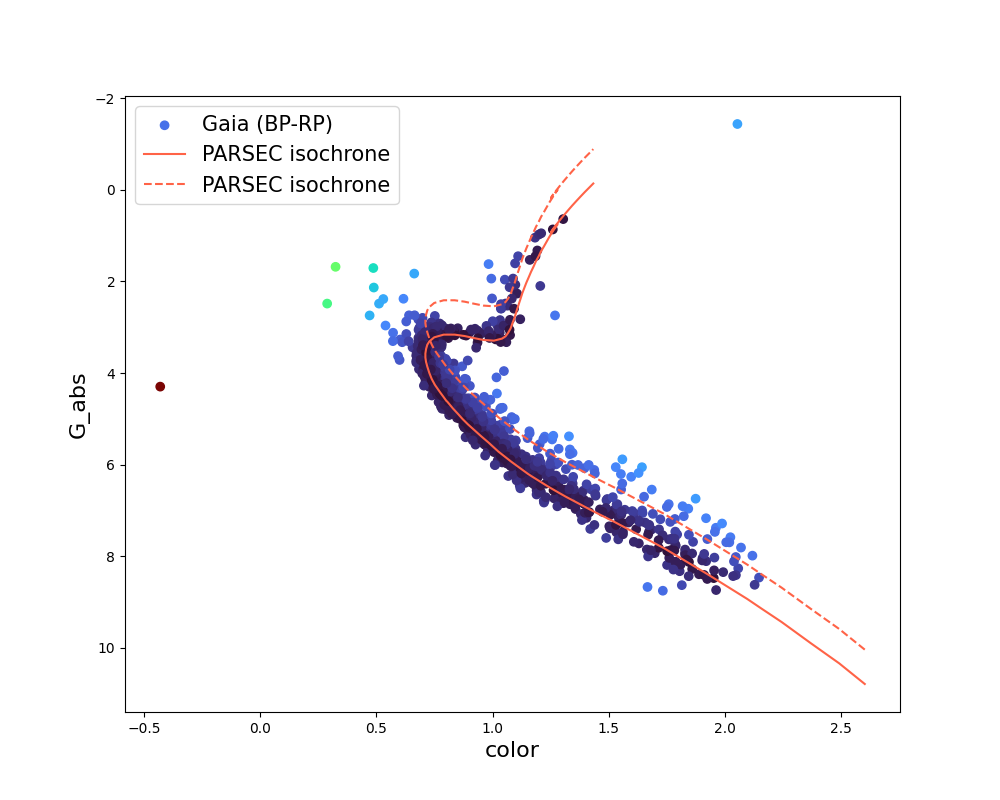

In [139]:
fig = plt.figure(figsize=(10, 8));
plt.scatter(sources_all['BP-RP'], sources_all['G_abs'],
            c=dists, cmap='turbo', label='Gaia (BP-RP)')
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1], label='PARSEC isochrone', color='tomato')
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1]-0.75, label='PARSEC isochrone', color='tomato', linestyle='--')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

In [140]:
np.std(dists)

0.032050708383792446

<IPython.core.display.Javascript object>


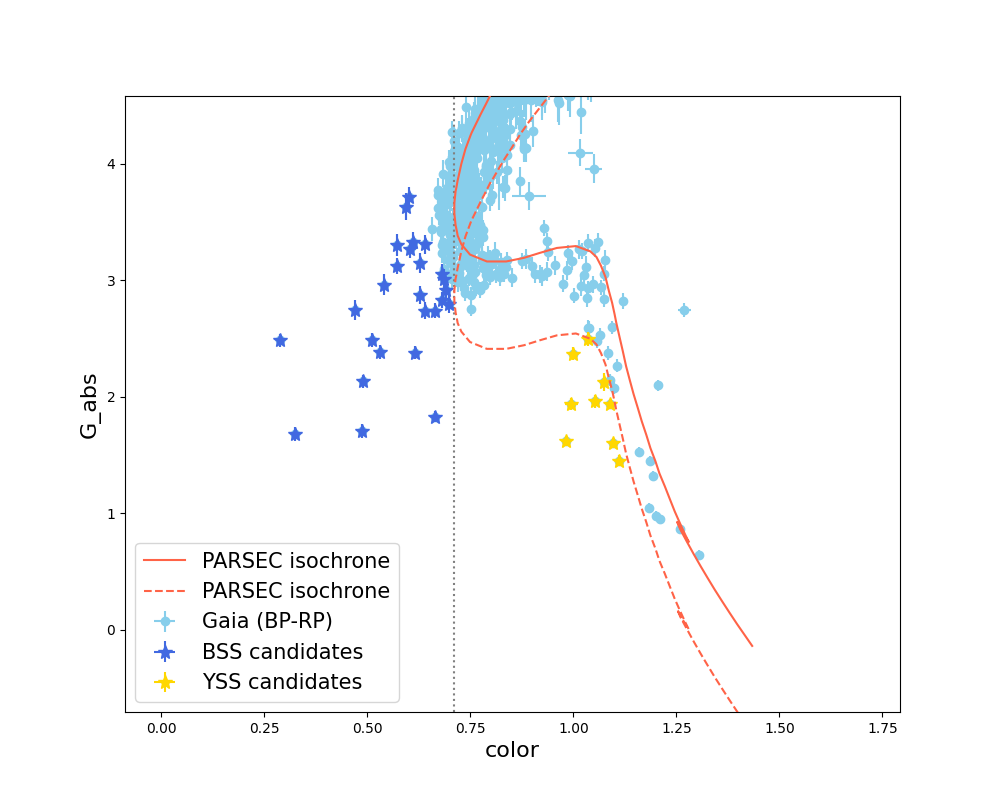

In [155]:
plt.figure(figsize=(10, 8));

TO_COLOR = np.min(isochrone_cut[:, 0])

plt.errorbar(sources_all['BP-RP'], sources_all['G_abs'],
             xerr=sources_all['BP-RP_error'], yerr=sources_all['G_abs_error'],
             color='skyblue', label='Gaia (BP-RP)', fmt='o', zorder=1)
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1], label='PARSEC isochrone', color='tomato', zorder=3)
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1]-0.75, label='PARSEC isochrone', color='tomato', zorder=3, linestyle='--')
bss_candidates = sources_all[((dists>=np.std(dists)) & (sources_all['BP-RP']<TO_COLOR) & (sources_all['BP-RP']>0))]
yss_candidates = sources_all[(sources_all['BP-RP']>TO_COLOR) & (sources_all['G_abs']<2.5) & (sources_all['BP-RP']<2.) &
                             ((above_equal_binary_limit) | (dists>=np.std(dists)))]
plt.errorbar(bss_candidates['BP-RP'], bss_candidates['G_abs'],
             xerr=bss_candidates['BP-RP_error'], yerr=bss_candidates['G_abs_error'],
             color='royalblue', fmt='*', zorder=2, label='BSS candidates', markersize=10.)
plt.errorbar(yss_candidates['BP-RP'], yss_candidates['G_abs'],
             xerr=yss_candidates['BP-RP_error'], yerr=yss_candidates['G_abs_error'],
             color='gold', fmt='*', zorder=2, label='YSS candidates', markersize=10.)
plt.axvline(x=TO_COLOR, color='gray', linestyle='dotted')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

In [166]:
len(bss_candidates)

26

In [167]:
len(yss_candidates)

9

# Download Gaia photometry if any

In [169]:
from astroquery.gaia import Gaia

In [171]:
retrieval_type = 'ALL'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'


datalink = Gaia.load_data(ids=bss_candidates['source_id'],
                          data_release = data_release,
                          retrieval_type= 'EPOCH_PHOTOMETRY',
                          data_structure = data_structure,
                          verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]
dl_keys.sort()

print()
print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')



The following Datalink products have been downloaded:
 * EPOCH_PHOTOMETRY-Gaia DR3 573944283722429952.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 573968576057423360.xml


In [175]:
dl_out = datalink['EPOCH_PHOTOMETRY-Gaia DR3 573944283722429952.xml'][0].to_table().to_pandas()

In [176]:
dl_out

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
0,573944283722429952,16794188979904685,G,1700.557556,15.022556,18446.934900,26.344404,700.222107,False,False,1,375316653866487564
1,573944283722429952,16798281267345192,G,1700.631566,14.997984,18869.177234,33.508351,563.118652,False,False,1,375316653866487564
2,573944283722429952,21033056143447168,G,1777.217809,14.983139,19128.956926,78.108717,244.901688,False,False,1021,375316653866487564
3,573944283722429952,22024321596408398,G,1795.144777,14.987913,19045.023858,15.632087,1218.328979,False,False,4194305,375316653866487564
4,573944283722429952,25274103025144796,G,1853.914651,14.986382,19071.906511,12.391667,1539.091309,False,False,1,375316653866487564
...,...,...,...,...,...,...,...,...,...,...,...,...
114,573944283722429952,63680499056657168,RP,2548.475958,14.508677,12464.859361,60.054832,207.557968,False,False,0,375316653866487564
115,573944283722429952,65792953363350052,RP,2586.677775,14.539376,12117.353064,54.227367,223.454575,False,False,0,375316653866487564
116,573944283722429952,65797045646958874,RP,2586.751778,14.494048,12633.941525,57.734010,218.830139,False,False,0,375316653866487564
117,573944283722429952,68946433283854891,RP,2643.704574,14.505618,12500.026490,56.504357,221.222351,False,False,0,375316653866487564


<IPython.core.display.Javascript object>


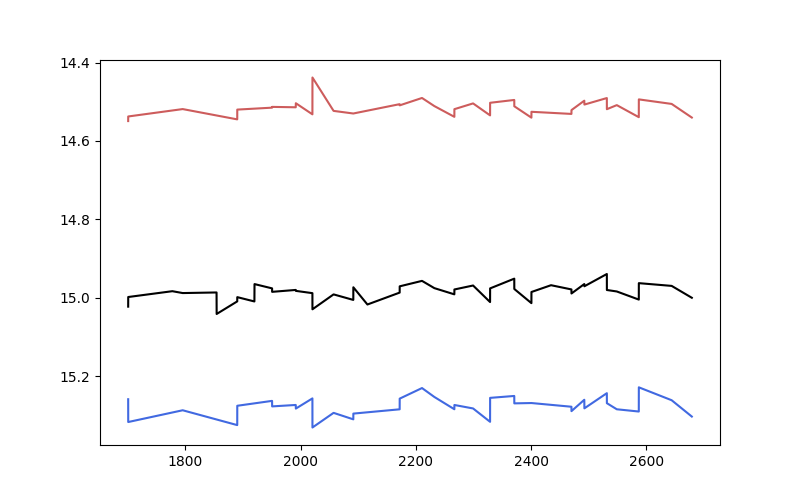

In [185]:
plt.figure(figsize=(8, 5));

g_mag = dl_out[dl_out['band']=='G']
rp_mag = dl_out[dl_out['band']=='RP']
bp_mag = dl_out[dl_out['band']=='BP']

plt.plot(g_mag.time, g_mag.mag, c='black');
plt.plot(rp_mag.time, rp_mag.mag, c='indianred');
plt.plot(bp_mag.time, bp_mag.mag, c='royalblue');
plt.gca().invert_yaxis();

In [186]:
photo2 = datalink['EPOCH_PHOTOMETRY-Gaia DR3 573968576057423360.xml'][0].to_table().to_pandas()

<IPython.core.display.Javascript object>


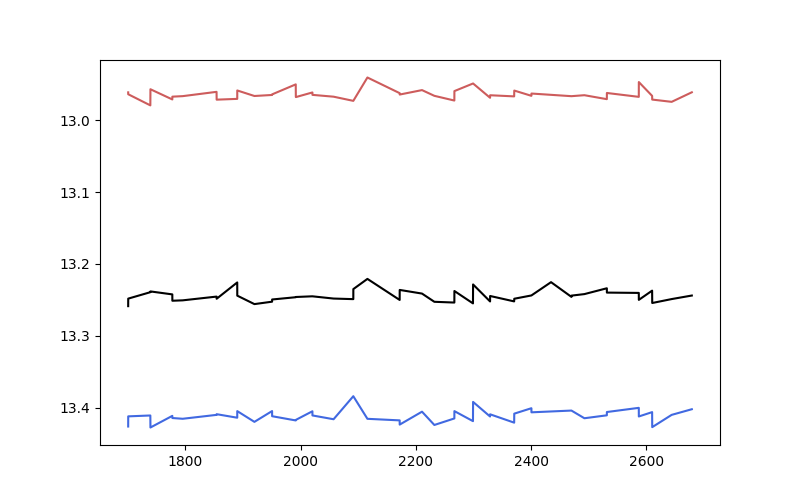

In [187]:
plt.figure(figsize=(8, 5));

g_mag = photo2[photo2['band']=='G']
rp_mag = photo2[photo2['band']=='RP']
bp_mag = photo2[photo2['band']=='BP']

plt.plot(g_mag.time, g_mag.mag, c='black');
plt.plot(rp_mag.time, rp_mag.mag, c='indianred');
plt.plot(bp_mag.time, bp_mag.mag, c='royalblue');
plt.gca().invert_yaxis();

In [194]:
bss_candidates.TIC

49             NaN
289    461618583.0
325    461618621.0
337    461618652.0
347            NaN
387    461618739.0
406    461618718.0
428    461618738.0
444    461618774.0
495    461601168.0
502    461601152.0
530    461601201.0
534            NaN
538    461601280.0
591    461601191.0
593    461599239.0
616    461599296.0
649    461601344.0
667    461601362.0
676    461601369.0
719    461601426.0
729    461599358.0
883    461618834.0
956    461601525.0
968    461620787.0
985    461593891.0
Name: TIC, dtype: float64

In [193]:
from lightkurve import search_lightcurve

In [197]:
lc = search_lightcurve(target='TIC 461618583', mission='TESS').download_all()

TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]

In [199]:
lc[0]

time,flux,flux_err,bge,quality,bgv,fdv,fkv,fsv,ife1,ife2,ife3,ifl1,ifl2,ifl3,ire1,ire2,ire3,irm1,irm2,irm3,irq1,irq2,irq3,rstfc,tmid_utc,xic,yic,ccdtemp,ntemps,bjdcorr,tfa1,tfa2,tfa3,pca1,pca2,pca3
,mag,mag,ADU,unitless,ADU,unitless,unitless,unitless,ADU,ADU,ADU,ADU,ADU,ADU,mag,mag,mag,mag,mag,mag,unitless,unitless,unitless,unitless,day,pix,pix,degcelcius,unitless,day,mag,mag,mag,mag,mag,mag
Time,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,str1,str1,str48,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2458790.679376087,14.20425,nan,0.38,G,-0.09,-0.0396725906,0.061242933,1.48822845,6.21,7.44,8.08,200.25,286.03,331.15,0.03365,0.02825,0.02648,14.20425,13.81716,13.65813,G,G,G,tess2019307035925-s0018-3-3-0162_cal_img_bkgdsub,2458790.6766716,213.500111,1866.58323,-80.1624842857143,28.0,0.0019037637659158838,14.12561338499583,13.73333970496433,13.546815937143993,14.124544785275932,13.821210007238912,13.609504832628517
2458790.7002100246,14.20379,nan,0.38,G,-0.12,-0.0397901548,0.0601248652,1.48516141,6.21,7.45,8.08,200.33,286.31,331.04,0.03364,0.02824,0.02649,14.20379,13.81608,13.65848,G,G,G,tess2019307042925-s0018-3-3-0162_cal_img_bkgdsub,2458790.697505,213.499946,1866.58121,-80.18622961904761,21.0,0.0019043009023061567,14.154894886350283,13.717859032887109,13.546888169830789,14.123822117436841,13.820707771550252,13.612919029649099
2458790.7210438615,14.20462,nan,0.35,G,-0.08,-0.0397684354,0.0599531114,1.48363467,6.2,7.44,8.05,200.18,286.29,330.83,0.03363,0.0282,0.02643,14.20462,13.81616,13.65917,G,G,G,tess2019307045925-s0018-3-3-0162_cal_img_bkgdsub,2458790.7183383,213.50039,1866.58343,-80.21007576923077,26.0,0.0019048377864382688,14.148560173574163,13.74527889169866,13.562420975308006,14.125002341222295,13.820017419135134,13.609523433621655
2458790.741877698,14.20953,nan,0.35,G,-0.14,-0.0388452286,0.059221711,1.48030117,6.19,7.43,8.06,199.28,285.93,331.61,0.03371,0.02822,0.0264,14.20953,13.81754,13.65662,G,G,G,tess2019307052925-s0018-3-3-0162_cal_img_bkgdsub,2458790.7391716,213.501546,1866.5833,-80.22811392,25.0,0.0019053744208231812,14.136826752146938,13.750137213928305,13.527289253979047,14.129387005544116,13.822552947757812,13.613101827662819
2458790.7627115343,14.20146,nan,0.39,G,-0.12,-0.0398514644,0.059518219,1.4828737,6.22,7.47,8.14,200.77,287.68,335.55,0.03362,0.02818,0.02633,14.20146,13.81089,13.64379,G,G,G,tess2019307055925-s0018-3-3-0162_cal_img_bkgdsub,2458790.7600049,213.501958,1866.58455,-80.24777843478259,23.0,0.0019059108053902313,14.143285739525622,13.72033711636523,13.541421897656146,14.121492117436842,13.815517771550253,13.598229029649097
2458790.7835454703,14.20035,nan,0.37,G,-0.2,-0.0396877582,0.0580985655,1.48113978,6.22,7.46,8.11,200.97,288.03,334.3,0.03358,0.02814,0.02633,14.20035,13.80958,13.64784,G,G,G,tess2019307062925-s0018-3-3-0162_cal_img_bkgdsub,2458790.7808383,213.50286,1866.5847,-80.26761752,25.0,0.0019064469426444933,14.151515885150847,13.762235732283855,13.508943765653294,14.119681669865935,13.815748476380492,13.610450221703982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458814.9089727188,13.3383,nan,8.91,G,-4.75,-0.0407291574,0.0608672306,1.47008692,18.28,26.63,38.63,444.58,772.56,1197.7,0.04465,0.03742,0.03502,13.3383,12.73834,12.26231,G,G,G,tess2019331092924-s0018-3-3-0162_cal_img_bkgdsub,2458814.9058281,213.456245,1866.5821,-79.93114075,24.0,0.0023438897911689125,14.169423254689098,13.697046572940817,13.593088958171528,14.099815407693434,13.609402419740475,13.392520245780789


<IPython.core.display.Javascript object>


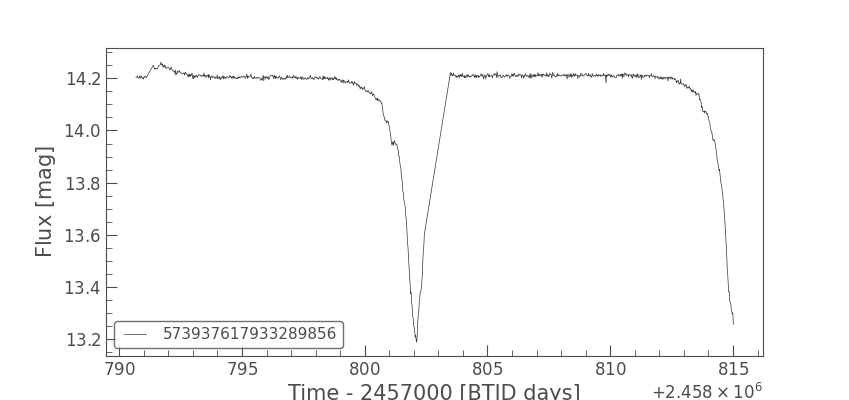

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{mag}$]'>

In [202]:
lc[0].plot()

In [210]:
[int(i) for i in bss_candidates.panstarrs1_id.values]

[209780139283378880,
 210190125233618880,
 210220123665889088,
 210250122272603040,
 210260120834059840,
 210310131083600128,
 210290125455103520,
 210300122644109216,
 210330124041933792,
 210240114877718560,
 210230112475697664,
 210270117991921312,
 210290117249573184,
 210300119648693856,
 210260111699553856,
 210260109234056576,
 210330105278576576,
 210330118060374112,
 210340115962815296,
 210350114865500704,
 210390110990344832,
 210410108496721696,
 210410124451261312,
 210530110892500864,
 210640136315263936,
 210370066859952832]

In [219]:
query = '''
SELECT
                  objID, detectID, Detection.filterID as filterID, Filter.filterType, obsTime, ra, dec,
                  psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
                  apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
              FROM Detection
              NATURAL JOIN Filter
              WHERE objID=210330118060374112
              ORDER BY filterID, obsTime
'''

https://ps1images.stsci.edu/ps1_dr2_api.html

In [220]:
import pyvo as vo

PANSTARRS1 = vo.dal.TAPService("http://vao.stsci.edu/PS1DR2/tapservice.aspx")

In [221]:
result = PANSTARRS1.run_async(query)

In [222]:
result

<Table length=0>
objID detectID filterid filterType ... apFluxErr infoFlag infoFlag2 infoFlag3
                                   ...                                       
int64  int64    uint8     object   ...  float32   int64     int32     int32  
----- -------- -------- ---------- ... --------- -------- --------- ---------